# Method 5 - Best Ideas Low Concentration

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Herfindahl

inst_data['target_sq'] = inst_data['target'] ** 2
herf = inst_data.groupby(['datadate', 'institution_id'])['target_sq'].sum().rename('herf').reset_index()

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Add Expected Returns per Shumway, Szefler, Yuan 2009

%store -r exp_ret

valid_data = valid_data.merge(exp_ret, on=['datadate', 'institution_id', 'fsym_id'], how='left')

# Calculate CSP Weight per Market Tilt

valid_data['adj_target'] = valid_data['expected_return']

## Calculate Best Ideas

In [3]:
# Extract Best Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] == 1].copy()

# Add Herf

best_ideas = best_ideas.merge(herf)
best_ideas['herf_pct'] = best_ideas.groupby('datadate')['herf'].rank(pct=True)
best_ideas = best_ideas[best_ideas['herf_pct'] < (1 / 3)]

# Weight the best ideas equally

best_ideas['target'] = 1 / best_ideas.groupby('datadate')['institution_id'].transform('count')

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

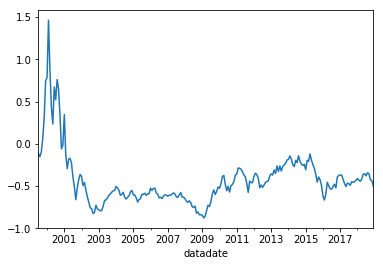

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.747325
2000-12-31   -0.437416
2001-12-31   -0.351923
2002-12-31   -0.641630
2003-12-31    0.958590
2004-12-31    0.003968
2005-12-31   -0.091356
2006-12-31   -0.040239
2007-12-31   -0.061207
2008-12-31   -0.562553
2009-12-31    2.041420
2010-12-31    0.286799
2011-12-31   -0.139882
2012-12-31    0.146301
2013-12-31    0.301152
2014-12-31   -0.061092
2015-12-31   -0.332988
2016-12-31    0.236978
2017-12-31   -0.091900
2018-12-31   -0.122003
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     169.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.78e-67
Time:                        04:12:12   Log-Likelihood:                 298.22
No. Observations:                 234   AIC:                            -586.4
Df Residuals:                     229   BIC:                            -569.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.991      0.323      -0.005       0.014
mktrf          1.3591      0.128     10.656      0.000       1.108       1.610
me             0.8082      0.148      5.448      0.000       0.516       1.101
ia            -0.3942      0.225     -1.748      0.082      -0.839       0.050
roe           -1.8046      0.193     -9.349      0.000      -2.185      -1.424
==============================================================================
Omnibus:                      151.264   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2001.514
Skew:                           2.287   Prob(JB):                         0.00
Kurtosis:                      16.578   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     111.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.15e-52
Time:                        04:12:12   Log-Likelihood:                 298.22
No. Observations:                 234   AIC:                            -586.4
Df Residuals:                     229   BIC:                            -569.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.953      0.340      -0.005       0.014
mktrf          1.3591      0.248      5.485      0.000       0.873       1.845
me             0.8082      0.185      4.360      0.000       0.445       1.172
ia            -0.3942      0.303     -1.300      0.194      -0.989       0.200
roe           -1.8046      0.259     -6.954      0.000      -2.313      -1.296
==============================================================================
Omnibus:                      151.264   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2001.514
Skew:                           2.287   Prob(JB):                         0.00
Kurtosis:                      16.578   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.748
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     132.3
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.37e-58
Time:                        04:12:12   Log-Likelihood:                 298.22
No. Observations:                 234   AIC:                            -586.4
Df Residuals:                     229   BIC:                            -569.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.005      0.866      0.386      -0.006       0.015
mktrf          1.3591      0.245      5.539      0.000       0.878       1.840
me             0.8082      0.196      4.125      0.000       0.424       1.192
ia            -0.3942      0.314     -1.255      0.209      -1.010       0.221
roe           -1.8046      0.274     -6.577      0.000      -2.342      -1.267
==============================================================================
Omnibus:                      151.264   Durbin-Watson:                   2.057
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2001.514
Skew:                           2.287   Prob(JB):                         0.00
Kurtosis:                      16.578   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     127.7
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.81e-64
Time:                        04:12:12   Log-Likelihood:                 293.25
No. Observations:                 234   AIC:                            -574.5
Df Residuals:                     228   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.005      0.796      0.427      -0.006       0.013
mktrf          1.5225      0.131     11.637      0.000       1.265       1.780
smb            0.8052      0.173      4.664      0.000       0.465       1.145
hml            0.0878      0.204      0.432      0.666      -0.313       0.489
rmw           -1.7540      0.230     -7.621      0.000      -2.207      -1.300
cma           -0.0721      0.293     -0.247      0.805      -0.649       0.504
==============================================================================
Omnibus:                      141.401   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1220.507
Skew:                           2.261   Prob(JB):                    9.34e-266
Kurtosis:                      13.234   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     101.4
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           5.90e-56
Time:                        04:12:12   Log-Likelihood:                 293.25
No. Observations:                 234   AIC:                            -574.5
Df Residuals:                     228   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.005      0.738      0.460      -0.006       0.014
mktrf          1.5225      0.163      9.328      0.000       1.203       1.842
smb            0.8052      0.166      4.838      0.000       0.479       1.131
hml            0.0878      0.356      0.247      0.805      -0.609       0.785
rmw           -1.7540      0.246     -7.132      0.000      -2.236      -1.272
cma           -0.0721      0.370     -0.195      0.845      -0.797       0.653
==============================================================================
Omnibus:                      141.401   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1220.507
Skew:                           2.261   Prob(JB):                    9.34e-266
Kurtosis:                      13.234   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.737
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     108.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.20e-58
Time:                        04:12:12   Log-Likelihood:                 293.25
No. Observations:                 234   AIC:                            -574.5
Df Residuals:                     228   BIC:                            -553.8
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0039      0.006      0.662      0.508      -0.008       0.015
mktrf          1.5225      0.147     10.386      0.000       1.235       1.810
smb            0.8052      0.169      4.751      0.000       0.473       1.137
hml            0.0878      0.307      0.286      0.775      -0.514       0.689
rmw           -1.7540      0.246     -7.124      0.000      -2.236      -1.271
cma           -0.0721      0.331     -0.218      0.827      -0.720       0.576
==============================================================================
Omnibus:                      141.401   Durbin-Watson:                   1.897
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1220.507
Skew:                           2.261   Prob(JB):                    9.34e-266
Kurtosis:                      13.234   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     147.9
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.79e-62
Time:                        04:12:12   Log-Likelihood:                 286.41
No. Observations:                 234   AIC:                            -562.8
Df Residuals:                     229   BIC:                            -545.6
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.005     -0.436      0.663      -0.012       0.007
mktrf          1.6885      0.124     13.671      0.000       1.445       1.932
smb            1.6193      0.154     10.503      0.000       1.315       1.923
hml           -0.3949      0.153     -2.579      0.011      -0.697      -0.093
umd           -0.5947      0.100     -5.918      0.000      -0.793      -0.397
==============================================================================
Omnibus:                      127.482   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1126.699
Skew:                           1.956   Prob(JB):                    2.19e-245
Kurtosis:                      13.013   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     64.55
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.78e-36
Time:                        04:12:12   Log-Likelihood:                 286.41
No. Observations:                 234   AIC:                            -562.8
Df Residuals:                     229   BIC:                            -545.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.004     -0.470      0.638      -0.011       0.007
mktrf          1.6885      0.203      8.316      0.000       1.291       2.086
smb            1.6193      0.169      9.595      0.000       1.289       1.950
hml           -0.3949      0.262     -1.509      0.131      -0.908       0.118
umd           -0.5947      0.160     -3.728      0.000      -0.907      -0.282
==============================================================================
Omnibus:                      127.482   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1126.699
Skew:                           1.956   Prob(JB):                    2.19e-245
Kurtosis:                      13.013   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.721
Model:                            OLS   Adj. R-squared:                  0.716
Method:                 Least Squares   F-statistic:                     61.86
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.23e-35
Time:                        04:12:12   Log-Likelihood:                 286.41
No. Observations:                 234   AIC:                            -562.8
Df Residuals:                     229   BIC:                            -545.6
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0021      0.005     -0.444      0.657      -0.011       0.007
mktrf          1.6885      0.196      8.600      0.000       1.304       2.073
smb            1.6193      0.156     10.358      0.000       1.313       1.926
hml           -0.3949      0.261     -1.511      0.131      -0.907       0.117
umd           -0.5947      0.167     -3.569      0.000      -0.921      -0.268
==============================================================================
Omnibus:                      127.482   Durbin-Watson:                   1.869
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             1126.699
Skew:                           1.956   Prob(JB):                    2.19e-245
Kurtosis:                      13.013   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     90.92
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.09e-34
Time:                        04:12:13   Log-Likelihood:                 137.08
No. Observations:                 120   AIC:                            -264.2
Df Residuals:                     115   BIC:                            -250.2
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.008      1.322      0.189      -0.005       0.025
mktrf          1.1673      0.203      5.742      0.000       0.765       1.570
me             0.7612      0.201      3.791      0.000       0.363       1.159
ia            -0.8964      0.314     -2.851      0.005      -1.519      -0.274
roe           -1.7669      0.278     -6.349      0.000      -2.318      -1.216
==============================================================================
Omnibus:                       79.487   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.238
Skew:                           2.126   Prob(JB):                    9.30e-135
Kurtosis:                      13.265   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     128.1
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           2.03e-41
Time:                        04:12:13   Log-Likelihood:                 137.08
No. Observations:                 120   AIC:                            -264.2
Df Residuals:                     115   BIC:                            -250.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.007      1.423      0.155      -0.004       0.024
mktrf          1.1673      0.378      3.092      0.002       0.427       1.907
me             0.7612      0.241      3.152      0.002       0.288       1.234
ia            -0.8964      0.397     -2.257      0.024      -1.675      -0.118
roe           -1.7669      0.361     -4.894      0.000      -2.475      -1.059
==============================================================================
Omnibus:                       79.487   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.238
Skew:                           2.126   Prob(JB):                    9.30e-135
Kurtosis:                      13.265   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.760
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                     271.2
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.47e-57
Time:                        04:12:13   Log-Likelihood:                 137.08
No. Observations:                 120   AIC:                            -264.2
Df Residuals:                     115   BIC:                            -250.2
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0100      0.007      1.337      0.181      -0.005       0.025
mktrf          1.1673      0.377      3.094      0.002       0.428       1.907
me             0.7612      0.256      2.978      0.003       0.260       1.262
ia            -0.8964      0.358     -2.505      0.012      -1.598      -0.195
roe           -1.7669      0.400     -4.415      0.000      -2.551      -0.982
==============================================================================
Omnibus:                       79.487   Durbin-Watson:                   2.056
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              617.238
Skew:                           2.126   Prob(JB):                    9.30e-135
Kurtosis:                      13.265   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     74.13
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           3.36e-34
Time:                        04:12:13   Log-Likelihood:                 138.35
No. Observations:                 120   AIC:                            -264.7
Df Residuals:                     114   BIC:                            -248.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.008      1.377      0.171      -0.005       0.026
mktrf          1.5760      0.213      7.398      0.000       1.154       1.998
smb            0.8628      0.241      3.576      0.001       0.385       1.341
hml           -0.5204      0.296     -1.760      0.081      -1.106       0.065
rmw           -1.2820      0.349     -3.677      0.000      -1.973      -0.591
cma           -0.0994      0.382     -0.260      0.795      -0.856       0.657
==============================================================================
Omnibus:                       82.230   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.687
Skew:                           2.368   Prob(JB):                    1.03e-107
Kurtosis:                      11.724   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     61.45
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           9.27e-31
Time:                        04:12:13   Log-Likelihood:                 138.35
No. Observations:                 120   AIC:                            -264.7
Df Residuals:                     114   BIC:                            -248.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.007      1.579      0.114      -0.003       0.024
mktrf          1.5760      0.282      5.592      0.000       1.024       2.128
smb            0.8628      0.240      3.589      0.000       0.392       1.334
hml           -0.5204      0.242     -2.151      0.031      -0.995      -0.046
rmw           -1.2820      0.314     -4.082      0.000      -1.898      -0.666
cma           -0.0994      0.397     -0.251      0.802      -0.877       0.678
==============================================================================
Omnibus:                       82.230   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.687
Skew:                           2.368   Prob(JB):                    1.03e-107
Kurtosis:                      11.724   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.754
Method:                 Least Squares   F-statistic:                     63.96
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.76e-31
Time:                        04:12:13   Log-Likelihood:                 138.35
No. Observations:                 120   AIC:                            -264.7
Df Residuals:                     114   BIC:                            -248.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0106      0.007      1.427      0.154      -0.004       0.025
mktrf          1.5760      0.236      6.672      0.000       1.113       2.039
smb            0.8628      0.229      3.770      0.000       0.414       1.311
hml           -0.5204      0.163     -3.192      0.001      -0.840      -0.201
rmw           -1.2820      0.322     -3.977      0.000      -1.914      -0.650
cma           -0.0994      0.322     -0.308      0.758      -0.731       0.532
==============================================================================
Omnibus:                       82.230   Durbin-Watson:                   1.826
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              492.687
Skew:                           2.368   Prob(JB):                    1.03e-107
Kurtosis:                      11.724   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     99.93
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.71e-36
Time:                        04:12:13   Log-Likelihood:                 141.44
No. Observations:                 120   AIC:                            -272.9
Df Residuals:                     115   BIC:                            -258.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.007      0.649      0.518      -0.009       0.019
mktrf          1.6677      0.173      9.657      0.000       1.326       2.010
smb            1.5349      0.197      7.806      0.000       1.145       1.924
hml           -0.9032      0.197     -4.586      0.000      -1.293      -0.513
umd           -0.5417      0.121     -4.461      0.000      -0.782      -0.301
==============================================================================
Omnibus:                       76.883   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.111
Skew:                           2.060   Prob(JB):                    1.43e-122
Kurtosis:                      12.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     101.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           7.51e-37
Time:                        04:12:13   Log-Likelihood:                 141.44
No. Observations:                 120   AIC:                            -272.9
Df Residuals:                     115   BIC:                            -258.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.787      0.431      -0.007       0.016
mktrf          1.6677      0.277      6.011      0.000       1.124       2.212
smb            1.5349      0.179      8.584      0.000       1.184       1.885
hml           -0.9032      0.272     -3.316      0.001      -1.437      -0.369
umd           -0.5417      0.167     -3.242      0.001      -0.869      -0.214
==============================================================================
Omnibus:                       76.883   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.111
Skew:                           2.060   Prob(JB):                    1.43e-122
Kurtosis:                      12.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.777
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     210.6
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           6.17e-52
Time:                        04:12:13   Log-Likelihood:                 141.44
No. Observations:                 120   AIC:                            -272.9
Df Residuals:                     115   BIC:                            -258.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0046      0.006      0.750      0.453      -0.007       0.017
mktrf          1.6677      0.269      6.197      0.000       1.140       2.195
smb            1.5349      0.157      9.786      0.000       1.227       1.842
hml           -0.9032      0.217     -4.156      0.000      -1.329      -0.477
umd           -0.5417      0.184     -2.950      0.003      -0.902      -0.182
==============================================================================
Omnibus:                       76.883   Durbin-Watson:                   1.838
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              561.111
Skew:                           2.060   Prob(JB):                    1.43e-122
Kurtosis:                      12.759   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     89.16
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-33
Time:                        04:12:13   Log-Likelihood:                 177.68
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.005     -0.351      0.726      -0.012       0.008
mktrf          1.6042      0.153     10.479      0.000       1.301       1.908
me             0.6962      0.236      2.945      0.004       0.228       1.165
ia             0.5354      0.328      1.633      0.105      -0.114       1.185
roe           -2.0455      0.288     -7.100      0.000      -2.616      -1.475
==============================================================================
Omnibus:                       18.623   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.624
Skew:                           0.736   Prob(JB):                     2.24e-07
Kurtosis:                       5.068   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     72.32
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.68e-30
Time:                        04:12:13   Log-Likelihood:                 177.68
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.433      0.665      -0.010       0.006
mktrf          1.6042      0.176      9.089      0.000       1.258       1.950
me             0.6962      0.325      2.139      0.032       0.058       1.334
ia             0.5354      0.372      1.438      0.151      -0.195       1.265
roe           -2.0455      0.511     -3.999      0.000      -3.048      -1.043
==============================================================================
Omnibus:                       18.623   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.624
Skew:                           0.736   Prob(JB):                     2.24e-07
Kurtosis:                       5.068   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.757
Method:                 Least Squares   F-statistic:                     77.84
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.68e-31
Time:                        04:12:13   Log-Likelihood:                 177.68
No. Observations:                 114   AIC:                            -345.4
Df Residuals:                     109   BIC:                            -331.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0018      0.004     -0.472      0.637      -0.009       0.006
mktrf          1.6042      0.168      9.548      0.000       1.275       1.934
me             0.6962      0.367      1.898      0.058      -0.023       1.415
ia             0.5354      0.410      1.307      0.191      -0.268       1.339
roe           -2.0455      0.522     -3.919      0.000      -3.069      -1.022
==============================================================================
Omnibus:                       18.623   Durbin-Watson:                   2.065
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               30.624
Skew:                           0.736   Prob(JB):                     2.24e-07
Kurtosis:                       5.068   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     70.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.83e-32
Time:                        04:12:13   Log-Likelihood:                 177.69
No. Observations:                 114   AIC:                            -343.4
Df Residuals:                     108   BIC:                            -327.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.005     -0.822      0.413      -0.015       0.006
mktrf          1.6393      0.147     11.177      0.000       1.349       1.930
smb            0.5980      0.238      2.511      0.014       0.126       1.070
hml            1.1505      0.304      3.789      0.000       0.549       1.752
rmw           -1.8026      0.372     -4.848      0.000      -2.540      -1.066
cma           -0.1576      0.472     -0.334      0.739      -1.093       0.778
==============================================================================
Omnibus:                       30.258   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.929
Skew:                           0.844   Prob(JB):                     2.70e-23
Kurtosis:                       7.362   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     66.69
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.96e-31
Time:                        04:12:13   Log-Likelihood:                 177.69
No. Observations:                 114   AIC:                            -343.4
Df Residuals:                     108   BIC:                            -327.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.006     -0.745      0.456      -0.016       0.007
mktrf          1.6393      0.140     11.669      0.000       1.364       1.915
smb            0.5980      0.239      2.500      0.012       0.129       1.067
hml            1.1505      0.253      4.555      0.000       0.655       1.645
rmw           -1.8026      0.470     -3.832      0.000      -2.725      -0.881
cma           -0.1576      0.392     -0.402      0.688      -0.926       0.611
==============================================================================
Omnibus:                       30.258   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.929
Skew:                           0.844   Prob(JB):                     2.70e-23
Kurtosis:                       7.362   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.755
Method:                 Least Squares   F-statistic:                     80.53
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.04e-35
Time:                        04:12:13   Log-Likelihood:                 177.69
No. Observations:                 114   AIC:                            -343.4
Df Residuals:                     108   BIC:                            -327.0
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0043      0.006     -0.745      0.456      -0.016       0.007
mktrf          1.6393      0.149     11.005      0.000       1.347       1.931
smb            0.5980      0.266      2.246      0.025       0.076       1.120
hml            1.1505      0.228      5.053      0.000       0.704       1.597
rmw           -1.8026      0.462     -3.905      0.000      -2.707      -0.898
cma           -0.1576      0.415     -0.379      0.704      -0.972       0.656
==============================================================================
Omnibus:                       30.258   Durbin-Watson:                   1.904
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              103.929
Skew:                           0.844   Prob(JB):                     2.70e-23
Kurtosis:                       7.362   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     75.70
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           1.42e-30
Time:                        04:12:13   Log-Likelihood:                 170.68
No. Observations:                 114   AIC:                            -331.4
Df Residuals:                     109   BIC:                            -317.7
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.006     -1.072      0.286      -0.017       0.005
mktrf          1.6998      0.154     11.019      0.000       1.394       2.006
smb            1.0198      0.241      4.239      0.000       0.543       1.497
hml            1.0527      0.248      4.249      0.000       0.562       1.544
umd           -0.5874      0.187     -3.143      0.002      -0.958      -0.217
==============================================================================
Omnibus:                       32.608   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.560
Skew:                           0.846   Prob(JB):                     3.66e-30
Kurtosis:                       8.067   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     92.05
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           4.84e-34
Time:                        04:12:13   Log-Likelihood:                 170.68
No. Observations:                 114   AIC:                            -331.4
Df Residuals:                     109   BIC:                            -317.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.005     -1.133      0.257      -0.016       0.004
mktrf          1.6998      0.156     10.912      0.000       1.394       2.005
smb            1.0198      0.240      4.249      0.000       0.549       1.490
hml            1.0527      0.258      4.074      0.000       0.546       1.559
umd           -0.5874      0.155     -3.802      0.000      -0.890      -0.285
==============================================================================
Omnibus:                       32.608   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.560
Skew:                           0.846   Prob(JB):                     3.66e-30
Kurtosis:                       8.067   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.735
Model:                            OLS   Adj. R-squared:                  0.726
Method:                 Least Squares   F-statistic:                     106.8
Date:                Tue, 28 Apr 2020   Prob (F-statistic):           8.81e-37
Time:                        04:12:13   Log-Likelihood:                 170.68
No. Observations:                 114   AIC:                            -331.4
Df Residuals:                     109   BIC:                            -317.7
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0059      0.005     -1.137      0.255      -0.016       0.004
mktrf          1.6998      0.159     10.667      0.000       1.387       2.012
smb            1.0198      0.229      4.462      0.000       0.572       1.468
hml            1.0527      0.257      4.097      0.000       0.549       1.556
umd           -0.5874      0.144     -4.089      0.000      -0.869      -0.306
==============================================================================
Omnibus:                       32.608   Durbin-Watson:                   1.967
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              135.560
Skew:                           0.846   Prob(JB):                     3.66e-30
Kurtosis:                       8.067   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""